<a href="https://colab.research.google.com/github/HugoMagos0725/Analisis_de_datos/blob/main/Tarea3_Ajuste_de_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FCFM-BUAP, 2023**

## Proyecto: Ajuste de parametros
Nombre: Hugo Cuautle Magos

Matricula: 201847053

Materia: Análisis de datos

# Problema 1 

El archivo "Puebla_pos.cvs" son datos de los casos registrados (nuevos casos) para Puebla, reportados por la secretaría de salud. 

Carga los datos y grafica


In [1]:
import pandas as pd

from google.colab import drive 
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/MyDrive/Puebla_pos.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,FECHA_SINTOMAS,positivo
0,2020-03-02,1
1,2020-03-05,2
2,2020-03-08,3
3,2020-03-09,4
4,2020-03-10,3
...,...,...
673,2022-01-09,493
674,2022-01-10,556
675,2022-01-11,287
676,2022-01-12,149


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime 

df1=list(range(len(df['FECHA_SINTOMAS'])))

for i in df1:
  st=df['FECHA_SINTOMAS'][i]
  df1[i]=datetime.strptime(st,'%Y-%m-%d')

df['FECHA_SINTOMAS']=df1

In [3]:
import numpy as np

df['infectados']=np.cumsum(df['positivo'])
df

,FECHA_SINTOMAS,positivo,infectados
0,2020-03-02,1,1
1,2020-03-05,2,3
2,2020-03-08,3,6
3,2020-03-09,4,10
4,2020-03-10,3,13
...,...,...,...
673,2022-01-09,493,139030
674,2022-01-10,556,139586
675,2022-01-11,287,139873
676,2022-01-12,149,140022


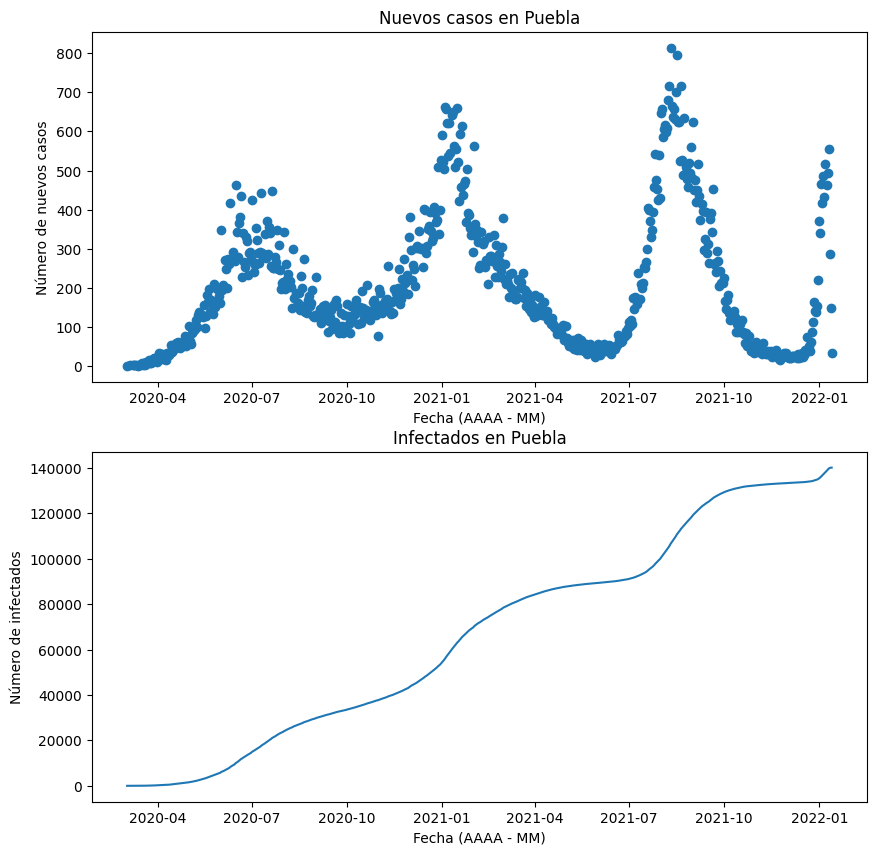

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.title('Nuevos casos en Puebla')
plt.xlabel('Fecha (AAAA - MM)')
plt.ylabel('Número de nuevos casos')
plt.scatter(df['FECHA_SINTOMAS'],df['positivo'])
plt.subplot(2, 1, 2)
plt.title('Infectados en Puebla')
plt.xlabel('Fecha (AAAA - MM)')
plt.ylabel('Número de infectados')
plt.plot(df['FECHA_SINTOMAS'],df['infectados'])
plt.show()

# Problema 2 

Ajustar la primera ola con mínimos cuadrados. 

In [5]:
ind=list(df['FECHA_SINTOMAS'].astype(str)).index('2020-10-10')

primera_ola=df['positivo'][:ind].astype(int)
t = np.linspace(0, ind,ind)
primera_ola

0        1
1        2
2        3
3        4
4        3
      ... 
212    155
213    124
214    129
215    133
216    133
Name: positivo, Length: 217, dtype: int64

In [6]:
from scipy import optimize
from scipy.integrate import odeint

def costo(x):
  b=x[0]
  g=x[1]
  def SIR(y,t,b,g):
    S=y[0]
    I=y[1]
    cum=y[2]
    N=4*I+S

    dS=-b*S*I/N
    dI=b*S*I/N-g*I
    dcum=b*S*I/N
    return np.array([dS,dI,dcum])

  y0=[sum(primera_ola)-1,1,1]
  model_pred=odeint(SIR,y0,t,args=(b,g))

  c=sum(np.array(primera_ola-model_pred[:,1])**2)
  return c

optimize.minimize(costo,[1,1],method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 493747.49353310786
             x: [ 1.090e+00  1.023e+00]
           nit: 50
          nfev: 92
 final_simplex: (array([[ 1.090e+00,  1.023e+00],
                       [ 1.090e+00,  1.023e+00],
                       [ 1.090e+00,  1.023e+00]]), array([ 4.937e+05,  4.937e+05,  4.937e+05]))

In [7]:
def SIR(y,t):
    
    b=1.09
    g=1.023

    S=y[0]
    I=y[1]
    cum=y[2]

    N=4*I+S

    dS=-b*S*I/N
    dI=b*S*I/N-g*I
    dcum=b*S*I/N
    return np.array([dS,dI,dcum])

y0=[sum(primera_ola)-1,1,1]

model_pred=odeint(SIR,y0,t)

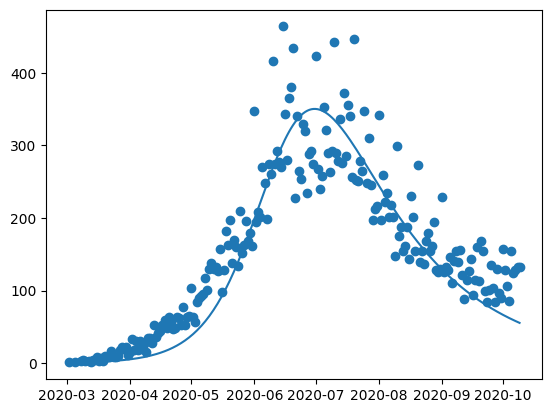

In [8]:
plt.plot(df['FECHA_SINTOMAS'][:ind],model_pred[:,1])
plt.scatter(df['FECHA_SINTOMAS'][:ind],primera_ola)
plt.show()

# Problema 3 

Ajustar la segunda ola con  una cadena de Monte Carlo y dar intervalos de confianza para los parámetros. 